In [1]:
!pip install roboflow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 40.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 88.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 97.9 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.11.0.86
    Uninstalling opencv-python-headless-4.11.0.86:
      Successfully uninstalled opencv-python-headless-4.11.0.86
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10


In [2]:
from roboflow import Roboflow
rf = Roboflow(api_key="3j9KnCrn3vCKxbGLZmCp")
project = rf.workspace("medi-nxjbd").project("medicineboxes-nmmta")
version = project.version(10)
dataset = version.download("coco")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to MedicineBoxes-10 in coco:: 100%|██████████| 1466/1466 [00:00<00:00, 7401.37it/s]


In [3]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [4]:
import os
import torchvision
import torch
from PIL import Image
import numpy as np
from torch.utils.data import DataLoader
from torch.utils.data import Subset
import random
import json
import matplotlib.pyplot as plt

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # interactive mode

In [6]:
def convert_bbox_tocrop(box):
    """function convert bbox from annotation or prediction
    bbox format = [x_min, y_min, width, height]
    crop area = [x_min, y_min, x_max, y_max]
    input box: list
    return crop_area: list
    """
    x_min = box[0]
    y_min = box[1]
    width = box[2]
    height = box[3]
    x_max = x_min + width
    y_max = y_min + height
    crop_area = [x_min, y_min, x_max, y_max]
    return crop_area



# Custom collate function for batching
def coco_collate_fn(batch):
    images, targets = zip(*batch)

    images = torch.stack(images, 0)
    targets = torch.cat(targets, 0)
    return images, targets

# Randomly sample 20% of the dataset indices
def get_subset(dataset, percentage):
    total_size = len(dataset)
    subset_size = int(total_size * percentage)
    indices = random.sample(range(total_size), subset_size)
    return Subset(dataset, indices)



In [7]:
import json

def convert_user_tags_to_annotations(json_path, output_path):
    with open(json_path, 'r') as f:
        coco_data = json.load(f)

    # 1. Map user_tag to category_id
    tag_to_id = {}
    new_categories = []
    new_annotations = []
    next_ann_id = 1
    next_cat_id = 0

    for image in coco_data['images']:
        user_tags = image.get('extra', {}).get('user_tags', [])

        if user_tags and isinstance(user_tags, list) and user_tags[0]:
            tag = user_tags[0]
        else:
            continue


        if tag not in tag_to_id:
            tag_to_id[tag] = next_cat_id
            new_categories.append({
                "id": next_cat_id,
                "name": tag
            })
            next_cat_id += 1

        # Add annotation
        new_annotations.append({
            "id": next_ann_id,
            "image_id": image['id'],
            "category_id": tag_to_id[tag]
        })
        next_ann_id += 1


    coco_data['annotations'] = new_annotations
    coco_data['categories'] = new_categories


    with open(output_path, 'w') as f:
        json.dump(coco_data, f, indent=4)

    print(f"Updated annotation file saved to: {output_path}")


In [8]:
# dataset = os.path.join(HOME, 'MedicineBoxes-2')
dataset = 'MedicineBoxes-10'
# Settings
ANNOTATION_FILE_NAME = "_annotations.coco.json"
TRAIN_DIRECTORY = os.path.join(dataset, "train")
VAL_DIRECTORY = os.path.join(dataset, "valid")
TEST_DIRECTORY = os.path.join(dataset, "test")

convert_user_tags_to_annotations(
    json_path= os.path.join(TRAIN_DIRECTORY, ANNOTATION_FILE_NAME),
    output_path=os.path.join(TRAIN_DIRECTORY,'_new_annotations_8classes.coco.json')
)
convert_user_tags_to_annotations(
    json_path= os.path.join(VAL_DIRECTORY, ANNOTATION_FILE_NAME),
    output_path=os.path.join(VAL_DIRECTORY,'_new_annotations_8classes.coco.json')
)
convert_user_tags_to_annotations(
    json_path= os.path.join(TEST_DIRECTORY, ANNOTATION_FILE_NAME),
    output_path=os.path.join(TEST_DIRECTORY,'_new_annotations_8classes.coco.json')
)

Updated annotation file saved to: MedicineBoxes-10/train/_new_annotations_8classes.coco.json
Updated annotation file saved to: MedicineBoxes-10/valid/_new_annotations_8classes.coco.json
Updated annotation file saved to: MedicineBoxes-10/test/_new_annotations_8classes.coco.json


In [9]:
output_path = os.path.join(TRAIN_DIRECTORY,'_new_annotations_8classes.coco.json')

In [10]:
# Path to your annotation file
annotation_file = output_path

# Load the annotation file
with open(annotation_file, 'r') as f:
    coco_data = json.load(f)

# Create a mapping of category_id to category_name
category_id_to_name = {category['id']: category['name'] for category in coco_data['categories']}
name_to_category_id = {v: k for k, v in category_id_to_name.items()}

# Example: Print the mapping
print("Category Mapping:", category_id_to_name)

Category Mapping: {0: 'Antihypertensives', 1: 'Antiplatelet-Agents', 2: 'Nitrates', 3: 'Anticoagulants', 4: 'Antiarrhythmics', 5: 'Statins', 6: 'Heart-Failure-Medications', 7: 'Combination-Medications'}


In [11]:
import json
from collections import defaultdict
train_anno_path = os.path.join(TRAIN_DIRECTORY,'_new_annotations_8classes.coco.json')
test_anno_path = os.path.join(TEST_DIRECTORY,'_new_annotations_8classes.coco.json')
val_anno_path = os.path.join(VAL_DIRECTORY,'_new_annotations_8classes.coco.json')

# Load COCO annotation JSON file
with open(test_anno_path, 'r') as f:
    coco = json.load(f)

# Map category_id to category_name
categories = {cat['id']: cat['name'] for cat in coco['categories']}

# Dictionary to hold unique image ids per category
images_per_category = defaultdict(set)

# Loop through annotations and collect image ids per category
for ann in coco['annotations']:
    category_id = ann['category_id']
    image_id = ann['image_id']
    images_per_category[category_id].add(image_id)

# Count images per category
for category_id, image_ids in images_per_category.items():
    print(f"Category '{categories[category_id]}' has {len(image_ids)} images")


Category 'Antihypertensives' has 45 images
Category 'Combination-Medications' has 6 images
Category 'Antiarrhythmics' has 8 images
Category 'Anticoagulants' has 16 images
Category 'Statins' has 29 images
Category 'Heart-Failure-Medications' has 9 images
Category 'Nitrates' has 10 images
Category 'Antiplatelet-Agents' has 11 images


In [12]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import os
from PIL import Image

# Custom Dataset Class
class CocoClassificationDataset(torchvision.datasets.CocoDetection):
    def __init__(self, image_directory_path: str, img_height=32, img_width=100, train=True, transform=None):
        annotation_file_path = os.path.join(image_directory_path, ANNOTATION_FILE_NAME)
        super(CocoClassificationDataset, self).__init__(image_directory_path, annotation_file_path)
        self.img_height = img_height
        self.img_width = img_width
        self.transform = transform  # Store transform

    def __getitem__(self, idx):
        # Get image and annotations using the parent class
        image, annotations = super(CocoClassificationDataset, self).__getitem__(idx)

        if annotations and 'bbox' in annotations[0]:
            bbox = annotations[0]['bbox']
            crop_bbox = convert_bbox_tocrop(bbox)
            image = image.crop(crop_bbox)

        if self.transform:
            image = self.transform(image)

        if annotations and 'category_id' in annotations[0]:
            class_label = annotations[0]['category_id']
            target = torch.tensor(class_label, dtype=torch.long)
            return image, target
        else:
            return None

# Custom collate function for batching
def coco_collate_fn(batch):
    batch = [b for b in batch if b is not None]
    if not batch:
        return torch.empty(0), torch.empty(0, dtype=torch.long)

    images, targets = zip(*batch)
    images = torch.stack(images, 0)
    targets = torch.tensor(targets, dtype=torch.long)
    return images, targets

In [13]:
# dataset = os.path.join(HOME, 'MedicineBoxes-2')
dataset = 'MedicineBoxes-10'
# Settings
ANNOTATION_FILE_NAME = "_new_annotations_8classes.coco.json"
# ANNOTATION_FILE_NAME = "_annotations.coco.json"
TRAIN_DIRECTORY = os.path.join(dataset, "train")
VAL_DIRECTORY = os.path.join(dataset, "valid")
TEST_DIRECTORY = os.path.join(dataset, "test")


# Define data augmentation for training


train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])




# Validation/Test transformations (NO augmentation)
val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])




# Load datasets
train_dataset = CocoClassificationDataset(TRAIN_DIRECTORY, transform=train_transform)
val_dataset = CocoClassificationDataset(VAL_DIRECTORY, transform=val_test_transform)
test_dataset = CocoClassificationDataset(TEST_DIRECTORY, transform=val_test_transform)


from torch.utils.data import WeightedRandomSampler
labels = []
for item in train_dataset:
    if item is not None:
        _, label = item
        labels.append(label.item())
train_labels_array = np.array(labels)

# Compute class counts
class_counts = np.bincount(train_labels_array)
weights = 1. / class_counts
sample_weights = weights[train_labels_array]

sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)



# DataLoaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, num_workers=2, collate_fn=coco_collate_fn, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=coco_collate_fn)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=coco_collate_fn)
# Check dataset sizes
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(val_dataset))
print("Number of validation examples:", len(test_dataset))

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Number of training examples: 925
Number of validation examples: 393
Number of validation examples: 140


In [14]:
# Path to your annotation file
annotation_file = os.path.join(TRAIN_DIRECTORY, ANNOTATION_FILE_NAME)

# Load the annotation file
with open(annotation_file, 'r') as f:
    coco_data = json.load(f)

# Create a mapping of category_id to category_name
category_id_to_name = {category['id']: category['name'] for category in coco_data['categories']}
name_to_category_id = {v: k for k, v in category_id_to_name.items()}

# Example: Print the mapping
print("Category Mapping:", category_id_to_name)

Category Mapping: {0: 'Antihypertensives', 1: 'Antiplatelet-Agents', 2: 'Nitrates', 3: 'Anticoagulants', 4: 'Antiarrhythmics', 5: 'Statins', 6: 'Heart-Failure-Medications', 7: 'Combination-Medications'}


In [ ]:
## Library

## Function

tensor([0, 4, 5, 6, 0, 0, 0, 2, 0, 6, 5, 0, 5, 6, 0, 1, 0, 5, 2, 3, 5, 2, 7, 7,
        0, 6, 0, 0, 1, 5])


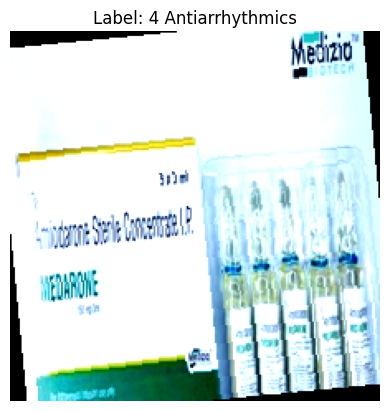

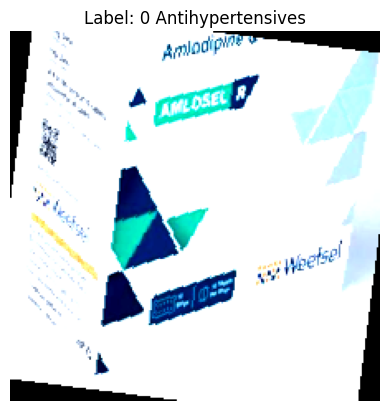

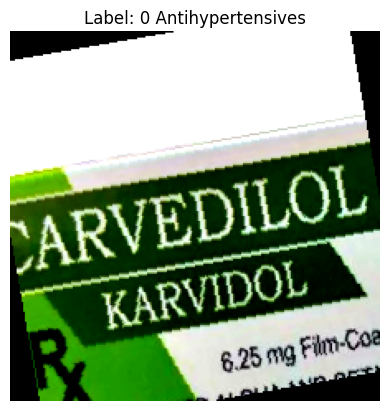

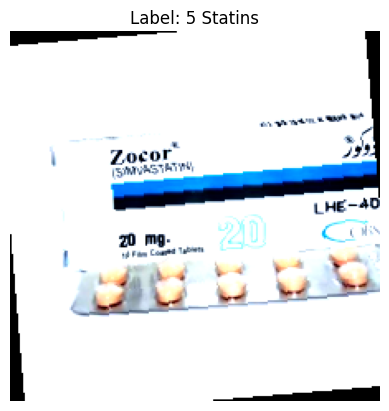

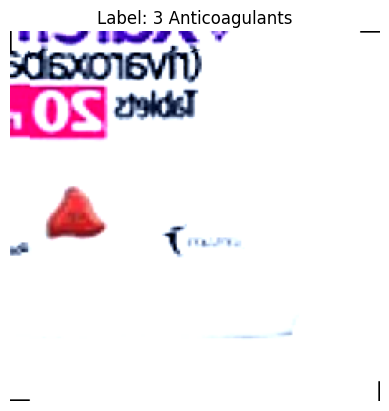

In [15]:

def show_image_with_label(image, label):
    """Display image with its readable label."""
    image = image.numpy().transpose((1, 2, 0))  # Convert (C, H, W) -> (H, W, C)
    image = (image + 1.0) / 2.0  # De-normalize from [-1, 1] to [0, 1]
    image = np.clip(image, 0, 1)  # Clip values to valid range
    plt.imshow(image)
    plt.title(f"Label: {label} {category_id_to_name.get(int(label))}")
    plt.axis("off")
    plt.show()


images, labels = next(iter(train_loader))
print(labels)
def display_batch(dataloader, num_images=5):
    images, labels = next(iter(dataloader))

    for i in range(min(num_images, len(images))):
        show_image_with_label(images[i], labels[i])

display_batch(train_loader, num_images=5)

In [16]:
class_names = [category['name'] for category in coco_data['categories']]
dataset_sizes = len(train_dataset) + len(val_dataset) + len(test_dataset)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [17]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# # Get a batch of training data
# inputs, classes = next(iter(train_loader))

# # Make a grid from batch
# out = torchvision.utils.make_grid(inputs)

# imshow(out, title=[class_names[x] for x in classes])

In [18]:
import time
from tempfile import TemporaryDirectory

def train_model(model, criterion, optimizer, scheduler, num_epochs=25, train_loader=None, val_loader=None):
    since = time.time()

    # Initialize lists to store loss and accuracy for plotting
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')
        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Training phase
            model.train()  # Set model to training mode
            running_loss = 0.0
            running_corrects = 0

            # Iterate over training data
            for inputs, labels in train_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # Backward + optimize only if in training phase
                loss.backward()
                optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            # Validation phase
            model.eval()  # Set model to evaluate mode
            val_loss = 0.0
            val_corrects = 0

            with torch.no_grad():  # No gradients needed during validation
                for inputs, labels in val_loader:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Statistics
                    val_loss += loss.item() * inputs.size(0)
                    val_corrects += torch.sum(preds == labels.data)

            # Update learning rate scheduler
            scheduler.step(val_loss)

            # Calculate losses and accuracies
            train_loss = running_loss / len(train_loader.dataset)
            train_acc = running_corrects.double() / len(train_loader.dataset)

            val_loss = val_loss / len(val_loader.dataset)
            val_acc = val_corrects.double() / len(val_loader.dataset)

            # Append the values for plotting
            train_losses.append(train_loss)
            train_accuracies.append(train_acc)
            val_losses.append(val_loss)
            val_accuracies.append(val_acc)

            # Print the results
            print(f'Train Loss: {train_loss:.4f} Train Acc: {train_acc:.4f}')
            print(f'Val Loss: {val_loss:.4f} Val Acc: {val_acc:.4f}')

            # Deep copy the model if we have a new best validation accuracy
            if val_acc > best_acc:
                best_acc = val_acc
                torch.save(model.state_dict(), best_model_params_path)

            print()

        # Load the best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

    # Return losses and accuracies to plot
    return model, train_losses, train_accuracies, val_losses, val_accuracies


In [19]:
# Example: when plotting an image from a tensor
def imshow(tensor, title=None):
    """Display image for Tensor."""
    tensor = tensor.cpu().numpy().transpose((1, 2, 0))  # Move tensor to CPU and convert to NumPy
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    tensor = std * tensor + mean
    tensor = np.clip(tensor, 0, 1)
    plt.imshow(tensor)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# In the plotting function for loss and accuracy:
def plot_learning_curves(train_losses, train_accuracies, val_losses, val_accuracies):
    num_epochs = len(train_losses)

    plt.figure(figsize=(12, 6))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(range(num_epochs), train_losses, label='Train Loss')
    plt.plot(range(num_epochs), val_losses, label='Val Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(range(num_epochs), train_accuracies, label='Train Accuracy')
    plt.plot(range(num_epochs), val_accuracies, label='Val Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Show plots
    plt.tight_layout()
    plt.show()


In [20]:
def visualize_model(model, num_images=6, val_loader=val_loader, class_names=class_names, device='cpu'):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j].item()]}')

                # Call imshow to display the image
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)



In [21]:
## Load pre-trained IMAGENET1K_V1 reset final fully connected layer.

## Train

### ResNet50

In [22]:
# Train


In [23]:
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features

# Replace fc first
model_ft.fc = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(num_ftrs, 256),
    nn.ReLU(),
    nn.Linear(256, 9)
)

# Freeze all parameters initially
for param in model_ft.parameters():
    param.requires_grad = False

# Unfreeze layer4 parameters
for name, param in model_ft.named_parameters():
    if "layer4" in name:
        param.requires_grad = True

# Unfreeze new fc parameters
for param in model_ft.fc.parameters():
    param.requires_grad = True

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss(label_smoothing=0.05)

# Optional: Use different learning rates for backbone and fc
optimizer_ft = optim.Adam([
    {'params': model_ft.layer4.parameters(), 'lr': 5e-4},
    {'params': model_ft.fc.parameters(), 'lr': 5e-4}
], weight_decay=1e-3)
# Learning rate scheduler
exp_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer_ft, mode='min', factor=0.5, patience=3, verbose=True)

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 210MB/s]
The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.


In [ ]:
### Train the model
model_ft, train_loss, train_acc, val_loss, val_acc = train_model(
    model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=100, train_loader=train_loader, val_loader=val_loader
)



In [ ]:
train_acc = np.array([t.cpu().numpy() for t in train_acc])
val_acc = np.array([t.cpu().numpy() for t in val_acc])

In [ ]:
# Plot the learning curves



print(f"Mean Train Accuracy: {np.mean(train_acc)}")
print(f"Mean Val Accuracy: {np.mean(val_acc)}")
print(f"Mean Train Loss: {np.mean(train_loss)}")
print(f"Mean Val Loss: {np.mean(val_loss)}")


plot_learning_curves(train_loss, train_acc, val_loss, val_acc)


In [25]:
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features

# Replace fc first
model_ft.fc = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(num_ftrs, 256),
    nn.ReLU(),
    nn.Linear(256, 9)
)

# Freeze all parameters initially
for param in model_ft.parameters():
    param.requires_grad = False

# Unfreeze layer4 parameters
for name, param in model_ft.named_parameters():
    if "layer4" in name:
        param.requires_grad = True

# Unfreeze new fc parameters
for param in model_ft.fc.parameters():
    param.requires_grad = True

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss(label_smoothing=0.05)

# Optional: Use different learning rates for backbone and fc
optimizer_ft = optim.Adam([
    {'params': model_ft.layer4.parameters(), 'lr': 5e-4},
    {'params': model_ft.fc.parameters(), 'lr': 5e-4}
], weight_decay=1e-3)
# Learning rate scheduler
exp_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer_ft, mode='min', factor=0.5, patience=3, verbose=True)

In [26]:
### Train the model
model_ft, train_loss, train_acc, val_loss, val_acc = train_model(
    model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=100, train_loader=train_loader, val_loader=val_loader
)



Epoch 0/99
----------
Train Loss: 1.8205 Train Acc: 0.3341
Val Loss: 2.3078 Val Acc: 0.1298

Epoch 1/99
----------
Train Loss: 1.6624 Train Acc: 0.3730
Val Loss: 2.6821 Val Acc: 0.1272

Epoch 2/99
----------
Train Loss: 1.6091 Train Acc: 0.3946
Val Loss: 2.3894 Val Acc: 0.2646

Epoch 3/99
----------
Train Loss: 1.5328 Train Acc: 0.4519
Val Loss: 3.0185 Val Acc: 0.1934

Epoch 4/99
----------
Train Loss: 1.5070 Train Acc: 0.4530
Val Loss: 2.2680 Val Acc: 0.3155

Epoch 5/99
----------
Train Loss: 1.4375 Train Acc: 0.4951
Val Loss: 2.6456 Val Acc: 0.2316

Epoch 6/99
----------
Train Loss: 1.3615 Train Acc: 0.5081
Val Loss: 2.6653 Val Acc: 0.2341

Epoch 7/99
----------
Train Loss: 1.3639 Train Acc: 0.5168
Val Loss: 2.6145 Val Acc: 0.2468

Epoch 8/99
----------
Train Loss: 1.2908 Train Acc: 0.5286
Val Loss: 2.6883 Val Acc: 0.2850

Epoch 9/99
----------
Train Loss: 1.1933 Train Acc: 0.5741
Val Loss: 2.5468 Val Acc: 0.2621

Epoch 10/99
----------
Train Loss: 1.0829 Train Acc: 0.6335
Val Loss: 

In [31]:
# Saving
torch.save(model_ft.state_dict(), "resnet_weights.pth")

In [33]:
# Loading
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features


# Replace fc first
model_ft.fc = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(num_ftrs, 256),
    nn.ReLU(),
    nn.Linear(256, 9)
)

# Freeze all parameters initially
for param in model_ft.parameters():
    param.requires_grad = False

# Unfreeze layer4 parameters
for name, param in model_ft.named_parameters():
    if "layer4" in name:
        param.requires_grad = True

# Unfreeze new fc parameters
for param in model_ft.fc.parameters():
    param.requires_grad = True


# Optional: Use different learning rates for backbone and fc
optimizer_ft = optim.Adam([
    {'params': model_ft.layer4.parameters(), 'lr': 5e-4},
    {'params': model_ft.fc.parameters(), 'lr': 5e-4}
], weight_decay=1e-3)

model_ft.load_state_dict(torch.load("resnet_weights.pth"))
model_ft.eval()

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [27]:
train_acc = np.array([t.cpu().numpy() for t in train_acc])
val_acc = np.array([t.cpu().numpy() for t in val_acc])

Mean Train Accuracy: 0.7897513513513513
Mean Val Accuracy: 0.24926208651399492
Mean Train Loss: 0.7131513642423861
Mean Val Loss: 2.9541482312867355


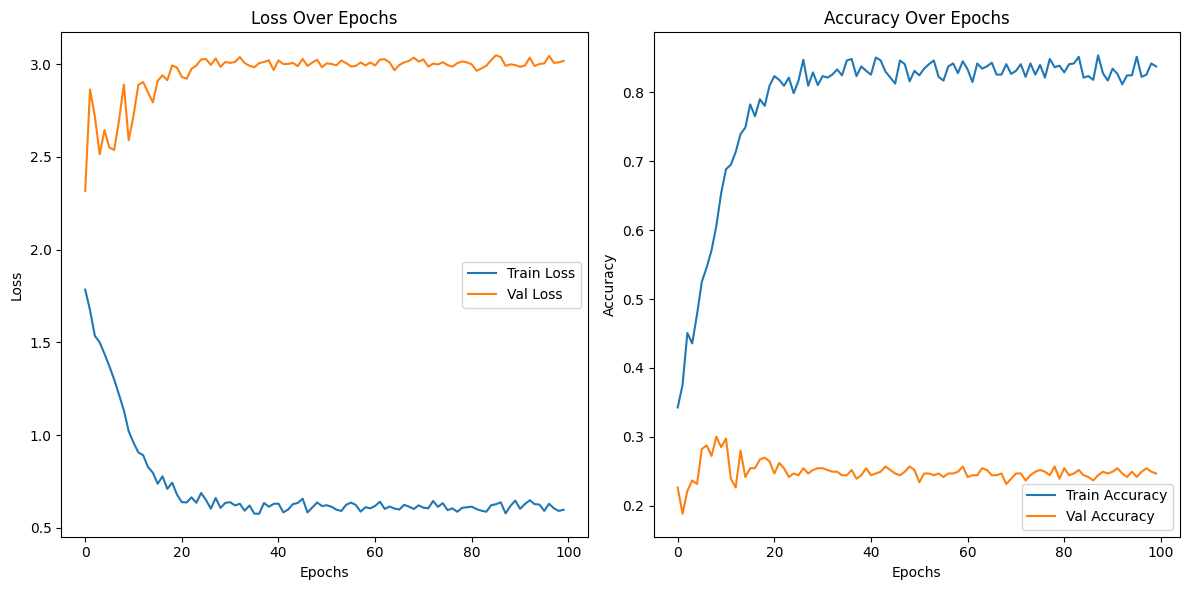

In [ ]:
# Plot the learning curves



print(f"Mean Train Accuracy: {np.mean(train_acc)}")
print(f"Mean Val Accuracy: {np.mean(val_acc)}")
print(f"Mean Train Loss: {np.mean(train_loss)}")
print(f"Mean Val Loss: {np.mean(val_loss)}")


plot_learning_curves(train_loss, train_acc, val_loss, val_acc)


### ResNet18

In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

# Replace the final FC layer
model_ft.fc = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(num_ftrs, 128),
    nn.ReLU(),
    nn.Linear(128, 9)
)

# Freeze all pretrained layers
for param in model_ft.parameters():
    param.requires_grad = False

# Unfreeze only the new FC layer
for param in model_ft.fc.parameters():
    param.requires_grad = True

for name, param in model_ft.named_parameters():
    if "layer2" in name or "layer3" in name or "layer4" in name:
        param.requires_grad = True


# Move to GPU if available
model_ft = model_ft.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss(label_smoothing=0.05)

optimizer_ft = optim.Adam([
    {'params': model_ft.fc.parameters(), 'lr': 1e-4},
    {'params': model_ft.layer4.parameters(), 'lr': 5e-5},
    {'params': model_ft.layer3.parameters(), 'lr': 2e-5},
    {'params': model_ft.layer2.parameters(), 'lr': 2e-5}
], weight_decay=1e-4)


# Learning rate scheduler
exp_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer_ft, mode='min', factor=0.5, patience=3, verbose=True)


Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.


In [ ]:
### Train the model
model_ft, train_loss, train_acc, val_loss, val_acc = train_model(
    model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=100, train_loader=train_loader, val_loader=val_loader
)



Epoch 0/99
----------
Train Loss: 2.0880 Train Acc: 0.1632
Val Loss: 2.0375 Val Acc: 0.2697

Epoch 1/99
----------
Train Loss: 1.8489 Train Acc: 0.3373
Val Loss: 1.9958 Val Acc: 0.3232

Epoch 2/99
----------
Train Loss: 1.7779 Train Acc: 0.3622
Val Loss: 2.0383 Val Acc: 0.3232

Epoch 3/99
----------
Train Loss: 1.7492 Train Acc: 0.3654
Val Loss: 2.0485 Val Acc: 0.3206

Epoch 4/99
----------
Train Loss: 1.7136 Train Acc: 0.3676
Val Loss: 2.0595 Val Acc: 0.3155

Epoch 5/99
----------
Train Loss: 1.6811 Train Acc: 0.3741
Val Loss: 2.0717 Val Acc: 0.3155

Epoch 6/99
----------
Train Loss: 1.6616 Train Acc: 0.3730
Val Loss: 2.0782 Val Acc: 0.2901

Epoch 7/99
----------
Train Loss: 1.6409 Train Acc: 0.3762
Val Loss: 2.0957 Val Acc: 0.2646

Epoch 8/99
----------
Train Loss: 1.6297 Train Acc: 0.3838
Val Loss: 2.1102 Val Acc: 0.2748

Epoch 9/99
----------
Train Loss: 1.6212 Train Acc: 0.3816
Val Loss: 2.1283 Val Acc: 0.2748

Epoch 10/99
----------
Train Loss: 1.5934 Train Acc: 0.3881
Val Loss: 

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7adc4dfc1a80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^Exception ignored in: ^^<function _MultiProcessingDataLoaderIter.__del__ at 0x7adc4dfc1a80>^
^Traceback (most recent call last):
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
^    ^self._shutdown_workers()^
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
^^    
if w.is_alive():  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive

     assert self._parent_pid == os.getpid(), 'can only test a child process' 
          ^ ^ ^ ^ ^ ^ ^^^^^^^^^^^^
^  Fil

Train Loss: 1.5567 Train Acc: 0.3924
Val Loss: 2.1609 Val Acc: 0.2519

Epoch 28/99
----------


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7adc4dfc1a80><function _MultiProcessingDataLoaderIter.__del__ at 0x7adc4dfc1a80>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
        if w.is_alive():if w.is_alive():

              ^^^^^^^^^^^^^^^^^^^^^^^^

  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
        assert self.

Train Loss: 1.5373 Train Acc: 0.4259
Val Loss: 2.1593 Val Acc: 0.2595

Epoch 29/99
----------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7adc4dfc1a80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^Exception ignored in: ^^<function _MultiProcessingDataLoaderIter.__del__ at 0x7adc4dfc1a80>^^
^Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
^^    ^self._shutdown_workers()^
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
^    ^if w.is_alive():^
^ ^ ^ ^ ^ 

Train Loss: 1.5510 Train Acc: 0.4130
Val Loss: 2.1597 Val Acc: 0.2545

Epoch 30/99
----------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7adc4dfc1a80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7adc4dfc1a80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Train Loss: 1.5549 Train Acc: 0.4141
Val Loss: 2.1615 Val Acc: 0.2570

Epoch 31/99
----------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7adc4dfc1a80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^Exception ignored in: ^^<function _MultiProcessingDataLoaderIter.__del__ at 0x7adc4dfc1a80>^
^Traceback (most recent call last):
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__

      File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
self._shutdown_workers()    
assert self._parent_pid == os.getpid(), 'can only test a child process'  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers

      if w.is_alive(): 
               ^^^^^^^^^^^^^^^^^^^^^^^^


Train Loss: 1.5492 Train Acc: 0.4227
Val Loss: 2.1564 Val Acc: 0.2646

Epoch 32/99
----------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7adc4dfc1a80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^Exception ignored in: ^^<function _MultiProcessingDataLoaderIter.__del__ at 0x7adc4dfc1a80>^
^Traceback (most recent call last):
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
^^    ^self._shutdown_workers()^

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
        if w.is_alive():assert self._parent_pid == os.getpid(), 'can only test a child process'

              ^ ^ ^ ^ ^^^^^^^^^^^^^^^^
^  F

Train Loss: 1.5415 Train Acc: 0.4119
Val Loss: 2.1604 Val Acc: 0.2621

Epoch 33/99
----------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7adc4dfc1a80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
Exception ignored in:     assert self._parent_pid == os.getpid(), 'can only test a child process'<function _MultiProcessingDataLoaderIter.__del__ at 0x7adc4dfc1a80>

 Traceback (most recent call last):
   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
       self._shutdown_workers() 
   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
       if w.is_alive():
 ^ ^ ^ ^ ^^ ^ ^ ^^^^^^^^^^^^^^^^^

Train Loss: 1.5337 Train Acc: 0.4065
Val Loss: 2.1641 Val Acc: 0.2570

Epoch 34/99
----------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7adc4dfc1a80>Exception ignored in: 
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7adc4dfc1a80>  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__

Traceback (most recent call last):
      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
self._shutdown_workers()
      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
self._shutdown_workers()
    if w.is_alive():  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers

     if w.is_alive(): 
          ^ ^ ^^^^^^^^^^^^^^^^^^^^
^  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
^
      File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
assert self._par

Train Loss: 1.5383 Train Acc: 0.4032
Val Loss: 2.1580 Val Acc: 0.2570

Epoch 35/99
----------
Train Loss: 1.5300 Train Acc: 0.4292
Val Loss: 2.1513 Val Acc: 0.2646

Epoch 36/99
----------
Train Loss: 1.5461 Train Acc: 0.4097
Val Loss: 2.1652 Val Acc: 0.2621

Epoch 37/99
----------
Train Loss: 1.5456 Train Acc: 0.4119
Val Loss: 2.1569 Val Acc: 0.2646

Epoch 38/99
----------
Train Loss: 1.5301 Train Acc: 0.4173
Val Loss: 2.1608 Val Acc: 0.2545

Epoch 39/99
----------
Train Loss: 1.5333 Train Acc: 0.4108
Val Loss: 2.1665 Val Acc: 0.2494

Epoch 40/99
----------
Train Loss: 1.5321 Train Acc: 0.4151
Val Loss: 2.1651 Val Acc: 0.2519

Epoch 41/99
----------
Train Loss: 1.5415 Train Acc: 0.4151
Val Loss: 2.1605 Val Acc: 0.2570

Epoch 42/99
----------
Train Loss: 1.5410 Train Acc: 0.4173
Val Loss: 2.1631 Val Acc: 0.2545

Epoch 43/99
----------
Train Loss: 1.5412 Train Acc: 0.4227
Val Loss: 2.1651 Val Acc: 0.2519

Epoch 44/99
----------
Train Loss: 1.5595 Train Acc: 0.4097
Val Loss: 2.1624 Val Ac

In [ ]:
train_acc = np.array([t.cpu().numpy() for t in train_acc])
val_acc = np.array([t.cpu().numpy() for t in val_acc])

Mean Train Accuracy: 0.4070486486486486
Mean Val Accuracy: 0.26033078880407123
Mean Train Loss: 1.5607517243411093
Mean Val Loss: 2.150392918253066


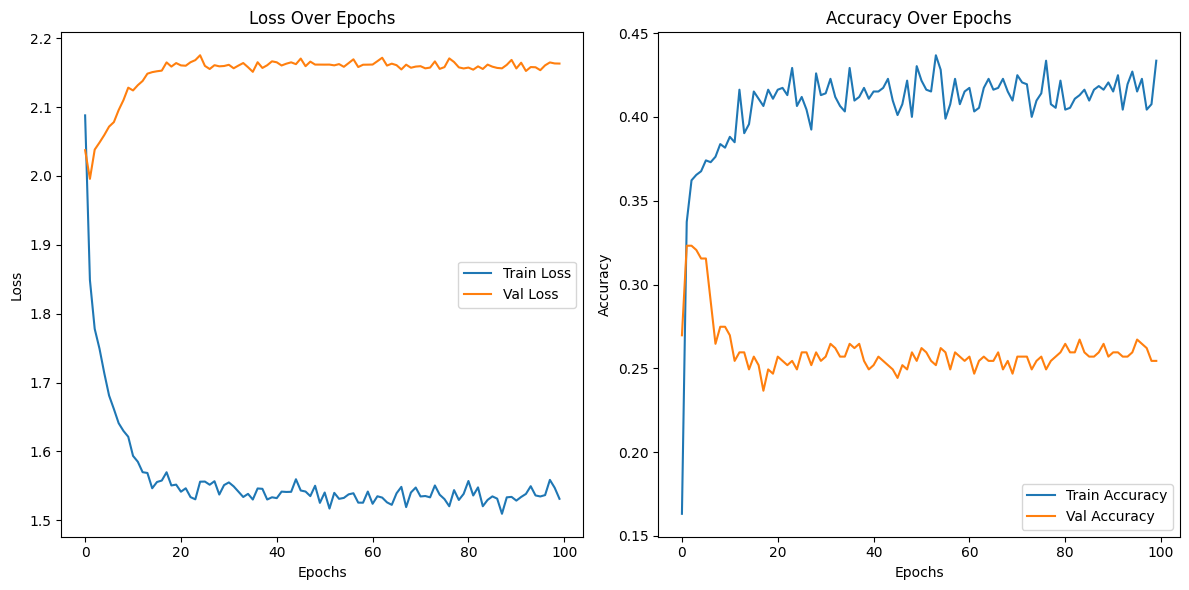

In [ ]:
# Plot the learning curves



print(f"Mean Train Accuracy: {np.mean(train_acc)}")
print(f"Mean Val Accuracy: {np.mean(val_acc)}")
print(f"Mean Train Loss: {np.mean(train_loss)}")
print(f"Mean Val Loss: {np.mean(val_loss)}")


plot_learning_curves(train_loss, train_acc, val_loss, val_acc)


## mobilenet_v2

In [ ]:
from torchvision import models

model_ft = models.mobilenet_v2(pretrained=True)
num_ftrs = model_ft.classifier[1].in_features

# Replace classifier
model_ft.classifier = nn.Sequential(
    nn.Dropout(p=0.3),
    nn.Linear(num_ftrs, 9)  # Your number of classes
)
for param in model_ft.parameters():
    param.requires_grad = False

for param in model_ft.classifier.parameters():
    param.requires_grad = True
criterion = nn.CrossEntropyLoss(label_smoothing=0.05)

optimizer_ft = optim.Adam([
    {'params': model_ft.classifier.parameters(), 'lr': 1e-4}
], weight_decay=1e-4)
model_ft = model_ft.to(device)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.5)


In [ ]:
### Train the model
model_ft, train_loss, train_acc, val_loss, val_acc = train_model(
    model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=100, train_loader=train_loader, val_loader=val_loader
)



Epoch 0/99
----------
Train Loss: 2.0166 Train Acc: 0.2173
Val Loss: 2.0182 Val Acc: 0.2519

Epoch 1/99
----------


The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.


Train Loss: 1.8827 Train Acc: 0.2768
Val Loss: 2.0278 Val Acc: 0.2188

Epoch 2/99
----------
Train Loss: 1.8780 Train Acc: 0.2692
Val Loss: 2.0315 Val Acc: 0.2163

Epoch 3/99
----------
Train Loss: 1.8585 Train Acc: 0.3049
Val Loss: 2.0336 Val Acc: 0.2112

Epoch 4/99
----------
Train Loss: 1.8590 Train Acc: 0.2832
Val Loss: 2.0303 Val Acc: 0.2239

Epoch 5/99
----------
Train Loss: 1.8544 Train Acc: 0.2886
Val Loss: 2.0309 Val Acc: 0.2214

Epoch 6/99
----------
Train Loss: 1.8619 Train Acc: 0.3027
Val Loss: 2.0316 Val Acc: 0.2112

Epoch 7/99
----------
Train Loss: 1.8513 Train Acc: 0.2984
Val Loss: 2.0333 Val Acc: 0.2087

Epoch 8/99
----------
Train Loss: 1.8796 Train Acc: 0.2778
Val Loss: 2.0281 Val Acc: 0.2163

Epoch 9/99
----------
Train Loss: 1.8599 Train Acc: 0.3005
Val Loss: 2.0296 Val Acc: 0.2137

Epoch 10/99
----------
Train Loss: 1.8740 Train Acc: 0.2800
Val Loss: 2.0296 Val Acc: 0.2036

Epoch 11/99
----------
Train Loss: 1.8750 Train Acc: 0.2822
Val Loss: 2.0307 Val Acc: 0.208

Mean Train Accuracy: 0.28537297297297304
Mean Val Accuracy: 0.21435114503816796
Mean Train Loss: 1.868527559517525
Mean Val Loss: 2.0303228498020855


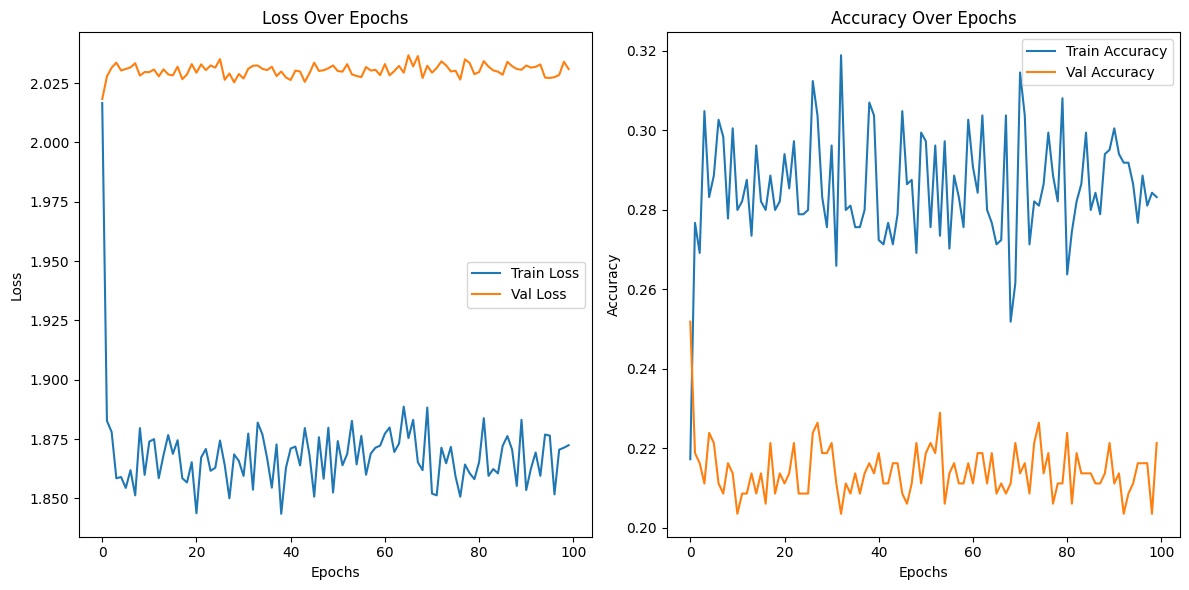

In [ ]:
# Plot the learning curves

train_acc = np.array([t.cpu().numpy() for t in train_acc])
val_acc = np.array([t.cpu().numpy() for t in val_acc])

print(f"Mean Train Accuracy: {np.mean(train_acc)}")
print(f"Mean Val Accuracy: {np.mean(val_acc)}")
print(f"Mean Train Loss: {np.mean(train_loss)}")
print(f"Mean Val Loss: {np.mean(val_loss)}")


plot_learning_curves(train_loss, train_acc, val_loss, val_acc)


In [ ]:
from torchvision import models

model_ft = models.mobilenet_v2(pretrained=True)
num_ftrs = model_ft.classifier[1].in_features

# Replace classifier
model_ft.classifier = nn.Sequential(
    nn.Dropout(p=0.6),
    nn.Linear(num_ftrs, 9)  # Your number of classes
)
for param in model_ft.parameters():
    param.requires_grad = False

for param in model_ft.classifier.parameters():
    param.requires_grad = True
criterion = nn.CrossEntropyLoss(label_smoothing=0.05)

for name, param in model_ft.features[-5:].named_parameters():  # last few blocks
    param.requires_grad = True



optimizer_ft = optim.Adam([
    {'params': model_ft.classifier.parameters(), 'lr': 1e-3},
    {'params': model_ft.features[-5:].parameters(), 'lr': 1e-5}
], weight_decay=1e-4)

model_ft = model_ft.to(device)

exp_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer_ft, mode='min', factor=0.5, patience=3, verbose=True)



In [ ]:
### Train the model
model_ft, train_loss, train_acc, val_loss, val_acc = train_model(
    model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=100, train_loader=train_loader, val_loader=val_loader
)



Epoch 0/99
----------
Train Loss: 1.7197 Train Acc: 0.3395
Val Loss: 2.1712 Val Acc: 0.3181

Epoch 1/99
----------
Train Loss: 1.6886 Train Acc: 0.3546
Val Loss: 2.1705 Val Acc: 0.3003

Epoch 2/99
----------
Train Loss: 1.6539 Train Acc: 0.3773
Val Loss: 2.2054 Val Acc: 0.3104

Epoch 3/99
----------
Train Loss: 1.6703 Train Acc: 0.3686
Val Loss: 2.1817 Val Acc: 0.3079

Epoch 4/99
----------
Train Loss: 1.6378 Train Acc: 0.3654
Val Loss: 2.2357 Val Acc: 0.3104

Epoch 5/99
----------
Train Loss: 1.6193 Train Acc: 0.3719
Val Loss: 2.2068 Val Acc: 0.3130

Epoch 6/99
----------
Train Loss: 1.6184 Train Acc: 0.4086
Val Loss: 2.2050 Val Acc: 0.3155

Epoch 7/99
----------
Train Loss: 1.6007 Train Acc: 0.3903
Val Loss: 2.2252 Val Acc: 0.3155

Epoch 8/99
----------
Train Loss: 1.5807 Train Acc: 0.3914
Val Loss: 2.2302 Val Acc: 0.3130

Epoch 9/99
----------
Train Loss: 1.6317 Train Acc: 0.3665
Val Loss: 2.2197 Val Acc: 0.3130

Epoch 10/99
----------
Train Loss: 1.6055 Train Acc: 0.3989
Val Loss: 

Mean Train Accuracy: 0.3898702702702703
Mean Val Accuracy: 0.3106361323155216
Mean Train Loss: 1.5996828838876775
Mean Val Loss: 2.2213642687409285


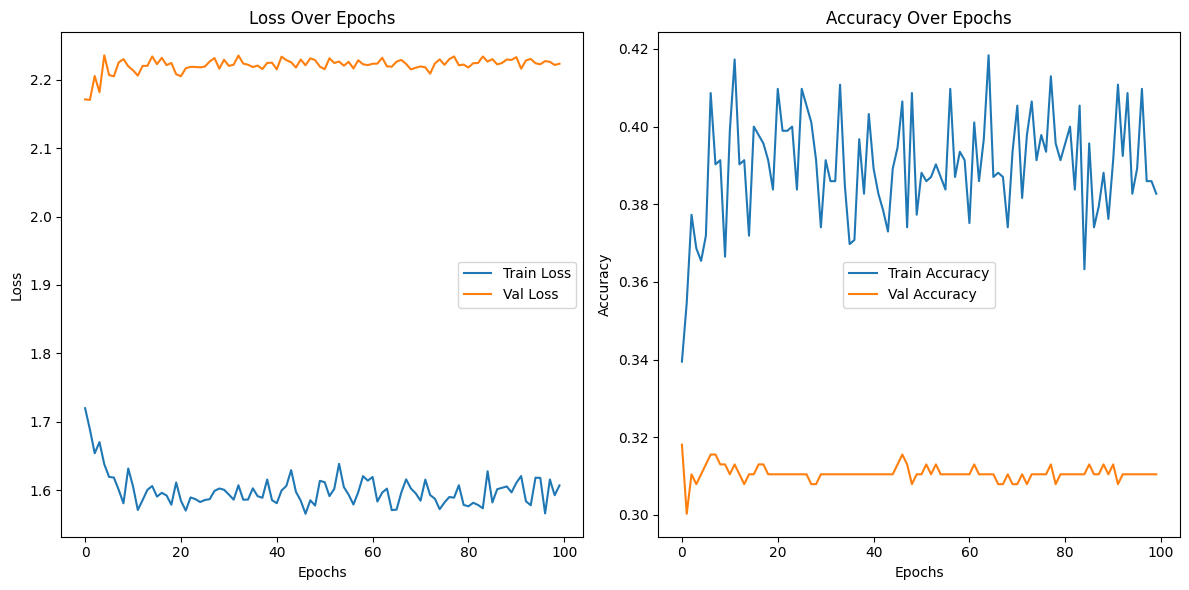

In [ ]:
# Plot the learning curves

train_acc = np.array([t.cpu().numpy() for t in train_acc])
val_acc = np.array([t.cpu().numpy() for t in val_acc])

print(f"Mean Train Accuracy: {np.mean(train_acc)}")
print(f"Mean Val Accuracy: {np.mean(val_acc)}")
print(f"Mean Train Loss: {np.mean(train_loss)}")
print(f"Mean Val Loss: {np.mean(val_loss)}")


plot_learning_curves(train_loss, train_acc, val_loss, val_acc)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#save

import numpy as np

np.save("content/drive/train_accuracy_8.npy", train_acc)
np.save("/content/drive/val_accuracy_8.npy", val_acc)
# train_acc = np.load("model_results/train_accuracy_8.npy")
# val_acc = np.load("model_results/val_accuracy_8.npy")
torch.save(model_ft.state_dict(), "/content/drive/resnet50_medicine_classifier_8.pt")



FileNotFoundError: [Errno 2] No such file or directory: 'content/drive/train_accuracy_8.npy'